In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import io

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
# Define global variables.
hidden_size = 100
num_classes = 228
learning_rate = 3e-4
num_train_steps = 10
num_train_per_eval = 2

# input_fn arguments.
should_augment = False
images_limit = 1000  # How many images to train.
batch_size = 32
num_threads = 8
input_folder = '/home/shared/cs231n-fashion/data/train_processed'
label_json_path = '/home/shared/cs231n-fashion/data/train.json'

In [4]:
# Set up some global variables
gpu_to_use = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_to_use)

In [8]:
from PIL import Image
import numpy as np
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _label_feature(labels):
    return _bytes_feature(''.join([str(i) for i in labels]))

tfrecords_filename = '/home/shared/cs231n-fashion/data/train_empty.tfrecords'

filename_pairs = [
('/home/shared/cs231n-fashion/data/train_processed/36.jpg', [1 for i in range(228)])
]
 
writer = tf.python_io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

for img_path, labels in filename_pairs:
    
    img = np.array(Image.open(img_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, labels))
    
    img_raw = img.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'label_raw': _int64_list_feature(labels)}))
    
    writer.write(example.SerializeToString())

writer.close()



In [9]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    labels = (example.features.feature['label_raw']
                                .int64_list.value)

    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    reconstructed_images.append((reconstructed_img, labels))

True
True


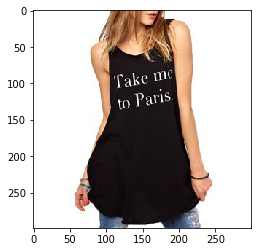

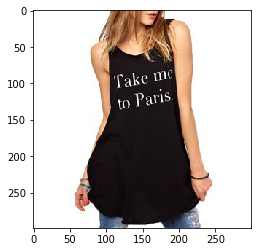

In [12]:
for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))
    plt.imshow(original_pair[0])
    plt.show()
    plt.imshow(reconstructed_pair[0])

In [ ]:
with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.int64)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32)
    
    # Cast label data into int32
    label = tf.cast(features['train/label'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)

In [26]:
def model_fn(features, labels, mode):
    """Model function for fashion classes predictions.
    
    Inputs:
        features: dict.
            Required key: "image". The value needs to have shape (batch_size, 299, 299, 3),
                and each value needs to be in range [0, 1].
        labels: shape (batch_size, num_classes)
        mode: tf.estimator.ModeKeys.(PREDICT|TRAIN|EVAL)
    
    Returns:
        estimator_spec.
    """
    # class_prob > threshold will be outputted.
    thresholds =[0.3, 0.5, 0.7]
    threshold = 0.5
#     threshold = tf.get_variable('threshold_unbound', initializer=0.5)
#     threshold = tf.clip_by_value(threshold, 0.1, 0.9, name='threshold')
    
    # Input layer.
    images = features
    module = hub.Module("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/1")
    features = module(images)  # (batch_size, D)
    
    # Create multi-head sigmoid outputs.
    # It measures the independent probability of a class showing in the image.
    raw_logits = tf.contrib.layers.fully_connected(
        inputs=features,
        num_outputs=num_classes,
        activation_fn=None)  # (batch_size, num_classes)
    
    raw_probs = tf.sigmoid(raw_logits)  # (batch_size, num_classes)
    
#     # RNN layer.
#     gru_cell = tf.nn.rnn_cell.GRUCell(hidden_size)
#     outputs, _ = tf.nn.dynamic_rnn(cell=gru_cell, inputs=)
    
    predictions = {
        'classes': raw_probs > threshold,
        'probs': raw_probs,
    }
    
    # PREDICT mode.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate loss (for both TRAIN and EVAL mode).
    loss = tf.losses.sigmoid_cross_entropy(
        multi_class_labels=labels,
        logits=raw_logits)
    
    # TRAIN mode.
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)    
    
    # Add evalutaion metrics (for EVAL mode).
    precisions = tf.metrics.precision_at_thresholds(
        labels=labels,
        predictions=predictions['probs'],
        thresholds=thresholds)
    recalls = tf.metrics.recall_at_thresholds(
        labels=labels,
        predictions=predictions['probs'],
        thresholds=thresholds)
    auc = tf.metrics.auc(
        labels=labels,
        predictions=predictions['probs'])
    
    mean_f1 = (2*precisions[0]*recalls[0]/(precisions[0]+recalls[0]), precisions[1])
    eval_metric_ops = {
        'precisions': precisions,
        'recalls': recalls,
        'auc': auc,
        'mean_f1': mean_f1,
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [27]:
run_config=tf.estimator.RunConfig(session_config=tf.ConfigProto(log_device_placement=True))

In [28]:
# Create the estimator.
classifier = tf.estimator.Estimator(
    config=run_config,
    model_fn=model_fn,
    model_dir='../model_dir/baseline')

INFO:tensorflow:Using config: {'_model_dir': '../model_dir/baseline', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': log_device_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f66f504a8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
import input_fn

train_input_fn = lambda: input_fn.input_fn(
        input_folder,
        label_json_path,
        augment=should_augment,
        batch_size=batch_size,
        num_threads=num_threads,
        images_limit=images_limit)

In [30]:
# Train the classifier.
# Run evaluation every num_train_per_eval training steps.
# Print the evalutation data and add the data into eval_data_list.

has_trained_steps = 0
eval_data_list = []

while has_trained_steps < num_train_steps:
    classifier.train(train_input_fn, steps=num_train_per_eval)
    
    # TODO: add eval_input_fn.
    eval_data = classifier.evaluate(train_input_fn, steps=1)
    print(eval_data)
    eval_data_list.append(eval_data)
    
    has_trained_steps += num_train_per_eval

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tf

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_3b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_3b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_4a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_4a_3x3/BatchNorm/beta
INFO:t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_mo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0b_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0a_1x1/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0b_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0c_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b3

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f8

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0a_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhu

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a33748

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branc

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0a_1x1/BatchNorm/m

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/blo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/blo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33c

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0b_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0b_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0b_1x3

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0b_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_1/Conv2d_0b_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_7b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_7b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_7b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_7b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnet

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_0/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_mo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b3

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhu

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a33748

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branc

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/BatchNorm/m

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/blo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/blo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33c

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b3

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_mo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_2/Conv2d_0c_3x3/BatchNo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Conv2d_1x1/bias

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/vari

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tf

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0a_1x1/BatchNorm/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_var

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_1/Conv2d_0b_3x3/BatchNorm/movi

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Con

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_1/Conv2d_

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0a_1x1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f8

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0b_1x7/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from chec

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0a_

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_1/Conv2d_0c_7x1/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0a_1x1/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Conv2d_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variabl

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0b_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0b_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0b_1x3/BatchNo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_1a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_2a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_2a_3x3/BatchNorm/beta
INFO:t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_mo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_1a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_1a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_1a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/var

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d_0a_1x1/BatchNorm/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_var

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0b_3x3/BatchNorm/movi

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0a_1x1/BatchNorm/movi

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Con

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0a_1x1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/C

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkp

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0a_1x1/Bat

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0c_3x1/BatchNo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0a_1x1/BatchNorm/mov

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Conv2d_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Conv2d_1x1/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-16-22:50:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../model_dir/baseline/mo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_2a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_2a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_2a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_2a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_2a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_2a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_2b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_2b_3x3/BatchNorm/beta
INFO:t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_mo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_6a/Branch_1/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_2/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0a_1x1/Bat

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_var

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_1/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_1/Conv2d_0b_3x3/BatchNorm/movi

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0a_1x1/BatchNorm/movi

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0b_3x3/BatchNorm/movi

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Branch_2/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_1/Con

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_11/Branch_1/Conv2d_

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0a_1x1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_14/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_17/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_17/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f8

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_2/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_2/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from c

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0a_

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_6/Branch_1/Conv2d_0c_7x1/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0a_1x1/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_9/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_9/C

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_3/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_3/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variabl

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0b_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0b_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0b_1x3/BatchNo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_6/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_6/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Branch_1

INFO:tensorflow:Done running local_init_op.


KeyboardInterrupt: 

In [31]:
# Example output for running evaluate function.
classifier.evaluate(train_input_fn, steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Block8/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tf

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_3b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_3b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_3b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Conv2d_4a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Conv2d_4a_3x3/BatchNorm/beta
INFO:t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_5b/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/t

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Mixed_7a/Branch_0/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_mo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_1/Branch_1/Conv2d_0b_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_10/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_2/Branch_2/Conv2d_0a_1x1/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_3/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_3/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_4/Branch_2/Conv2d_0b_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_5/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_5/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_6/Branch_2/Conv2d_0c_3x3/BatchN

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_7/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_7/B

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_8/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_8/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b3

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat/block35_9/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_1/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f8

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_10/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_12/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_13/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_13/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_15/Branch_1/Conv2d_0a_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_16/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_18/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_19/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_19/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhu

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_20/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_20/Branch_1

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_3/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_4/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_4/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a33748

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_5/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_7/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_7/Branc

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_1/block17_8/Branch_1/Conv2d

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_0/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_1/Branch_1/Conv2d_0a_1x1/BatchNorm/m

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/blo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_4/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/blo

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Branch_1/Conv2d_0c_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_5/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_5/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33c

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0b_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0b_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_7/Branch_1/Conv2d_0b_1x3

INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/biases
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_8/Conv2d_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_0/Conv2d_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f843fca5/variables/variables' with InceptionResnetV2/Repeat_2/block8_9/Branch_0/Conv2d_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionResnetV2/Repeat_2/block8_9/Branch_0/Conv2d_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/b33cf40b3b329fdcead0a337480d32b1f

{'auc': 0.66479385,
 'global_step': 14,
 'loss': 0.23256978,
 'mean_f1': array([0.12820512, 0.22018349, 0.11282051], dtype=float32),
 'precisions': array([0.0794702 , 0.6486486 , 0.78571427], dtype=float32),
 'recalls': array([0.3314917 , 0.13259669, 0.06077348], dtype=float32)}

In [ ]:
# Test cell to validate the input_fn.
# The output batch_images.shape should be (batch_size, 299, 299, 3)
#            batch_labels.shape should be (batch_size, 228)

should_augment = False
images_limit = 4  # How many images to train.
batch_size = 2
num_threads = 2
input_folder = '/home/shared/cs231n-fashion/data/train_processed'
label_json_path = '/home/shared/cs231n-fashion/data/train.json'

with tf.Session() as sess:
    next_batch = input_fn.input_fn(
        input_folder,
        label_json_path,
        augment=should_augment,
        batch_size=batch_size,
        num_threads=num_threads,
        images_limit=images_limit)
    for _ in range(5):
        batch_images, batch_labels = sess.run(next_batch)
        print(batch_images.shape, batch_labels.shape)
